In [1]:
!pip install -q kaggle

In [ ]:
from google.colab import files
#Upload Kaggle API Key
files.upload()

In [3]:
!mkdir ~/.kaggle #make new directory in root folder
!cp kaggle.json ~/.kaggle/ #copy and paste kaggle API key to new directory
!chmod 600 ~/.kaggle/kaggle.json #permission
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04           6116        197  1.0              
kaggleashwin/population-dataset                                World Population by Countries Dataset (1960-2021)    69KB  2022-08-31 05:30:26           1645         70  1.0              
iamsouravbanerjee/house-rent-prediction-dataset                House Rent Prediction Dataset                        82KB  2022-08-20 13:49:03          12103        307  1.0              
pantanjali/unemployment-dataset                                Un

In [4]:
!kaggle datasets download -d venky73/spam-mails-dataset

  0% 0.00/1.86M [00:00<?, ?B/s]
100% 1.86M/1.86M [00:00<00:00, 138MB/s]


In [5]:
import os
import zipfile
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Flatten, LSTM
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
zipPath = '../content/spam-mails-dataset.zip' #zip path in local 
zipFile = zipfile.ZipFile(zipPath, 'r')
zipFile.extractall('../content/spamMailDataset') #extract to new directory
zipFile.close() #close connection to object

In [7]:
filePath = '../content/spamMailDataset/spam_ham_dataset.csv'
df = pd.read_csv(filePath)
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [8]:
df = df.drop(columns = 'Unnamed: 0', axis = 1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [10]:
# No NaN in the data
df.isna().sum()

label        0
text         0
label_num    0
dtype: int64

In [11]:
#No NULL in the data
df.isnull().sum()

label        0
text         0
label_num    0
dtype: int64

In [12]:
df['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

In [13]:
stop_words = set(stopwords.words('english')) 

df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x if not w.lower() in stop_words]))

In [14]:
length = df['text'].str.len().max()
X = df['text'].values
y = df['label_num'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
tokenizer = Tokenizer(num_words=length, oov_token='<x>')
tokenizer.fit_on_texts(X_train) 
tokenizer.fit_on_texts(X_test)
 
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)
 
padded_train = pad_sequences(seq_train, maxlen=20) 
padded_test = pad_sequences(seq_test, maxlen=20)

In [16]:
#Architecture
model = Sequential([
    Embedding(250, 16, input_length=20),
    LSTM(64),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [17]:
model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
#Callback Function
class accCallback(Callback):
   def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.90 and logs.get('val_accuracy') >= 0.90):
            print("\nAccuracy and Val_Accuracy has reached 90%!", "\nEpoch: ", epoch)
            self.model.stop_training = True

callbacks = accCallback()

auto_reduction_LR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 2, #if after 2 epoch not improve reduce LR by factor
    verbose = 1,
    factor = 0.2,
    min_lr = 0.000003
)

auto_stop_learn = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    mode = 'auto' 
)

In [19]:
History = model.fit(
    padded_train, y_train, 
    epochs = 100, 
    callbacks=[callbacks, auto_reduction_LR, auto_stop_learn], 
    validation_data = (padded_test, y_test),
    verbose = 2
)

Epoch 1/100
130/130 - 5s - loss: 0.3539 - accuracy: 0.8690 - val_loss: 0.5357 - val_accuracy: 0.7111 - lr: 0.0010 - 5s/epoch - 38ms/step
Epoch 2/100
130/130 - 2s - loss: 0.2594 - accuracy: 0.9086 - val_loss: 0.4638 - val_accuracy: 0.7111 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 3/100
130/130 - 2s - loss: 0.2490 - accuracy: 0.9130 - val_loss: 0.4150 - val_accuracy: 0.7188 - lr: 0.0010 - 2s/epoch - 12ms/step
Epoch 4/100
130/130 - 2s - loss: 0.2485 - accuracy: 0.9139 - val_loss: 0.3054 - val_accuracy: 0.8995 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 5/100

Accuracy and Val_Accuracy has reached 90%! 
Epoch:  4
130/130 - 2s - loss: 0.2328 - accuracy: 0.9178 - val_loss: 0.2405 - val_accuracy: 0.9188 - lr: 0.0010 - 2s/epoch - 12ms/step


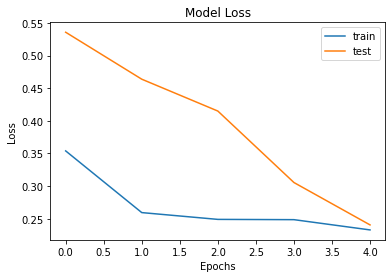

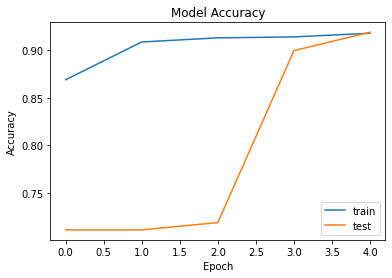

In [27]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()